# Functional API & Latent Space

In [19]:
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras import Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [20]:
from tensorflow.keras.utils import image_dataset_from_directory

In [21]:
ds = image_dataset_from_directory('/home/jupyter/data_local', label_mode=None, image_size=(448, 448), batch_size=32)

Found 2360 files belonging to 1 classes.


In [22]:
##ds = ds.map(lambda x: x/255)
##ds = ds.map(lambda x: (x, x))

In [23]:
imgs = ds.as_numpy_iterator().__next__()

In [24]:
imgs.shape

(32, 448, 448, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


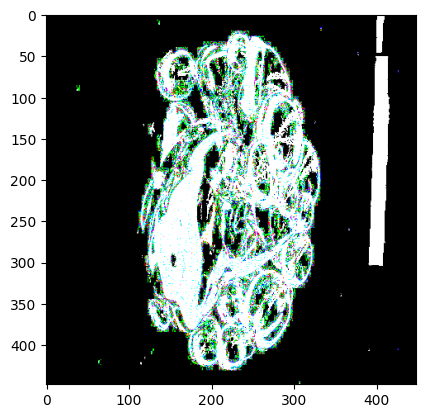

In [25]:
plt.imshow(imgs[0])


In [26]:
X_train=imgs/255

In [27]:
def build_encoder(latent_dimension):
    
    input_image = Input(shape=(448, 448, 3))
    
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_image)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    encoder_output = Dense(latent_dimension, activation='tanh')(x)
    
    z_mu = Dense(latent_dimension)(x)
    z_log_sigma = Dense(latent_dimension)(x)
    
    encoder = Model(inputs=input_image, outputs=[encoder_output, z_mu, z_log_sigma])

    return encoder





In [28]:
from keras import backend as K
latent_dimension = 100

input_image = Input(shape=(448, 448, 3))
    
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_image)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
    
x = Conv2D(256, (3, 3), padding='same', activation=LeakyReLU())(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
encoder_output = Dense(latent_dimension, activation='tanh')(x)

z_mu = Dense(latent_dimension)(x)
z_log_sigma = Dense(latent_dimension)(x)

In [29]:
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dimension),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

In [30]:
from keras.layers import Lambda
z = Lambda(sampling)([z_mu, z_log_sigma])

In [31]:


latent_space_input = Input(K.int_shape(z)[1:])
    
x = Dense(7*7*64, activation='tanh')(latent_space_input)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu')(x)
    
decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
decoder = Model(inputs=latent_space_input, outputs=decoder_output)
    
z_decoded = decoder(z)

In [47]:
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Layer

# # construct a custom layer to calculate the loss
# class CustomVariationalLayer(Layer):

#     def vae_loss(self, x, z_decoded):
#         x = K.flatten(x)
#         z_decoded = K.flatten(z_decoded)
#         # Reconstruction loss
#         xent_loss = binary_crossentropy(x, z_decoded)
#         # KL divergence
#         kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
#         return K.mean(xent_loss + kl_loss)

#     # adds the custom loss to the class
#     def call(self, inputs):
#         x = inputs[0]
#         z_decoded = inputs[1]
#         loss = self.vae_loss(x, z_decoded)
#         self.add_loss(loss, inputs=inputs)
#         return x

# # apply the custom loss to the input images and the decoded latent distribution sample
# y = CustomVariationalLayer()([input_image, z_decoded])

# # VAE model statement
# vae = Model(input_image, y)
# vae.compile(optimizer='rmsprop', loss=None)

# vae.fit(x=X_train,
#         shuffle=True,
#         epochs=20,
#         batch_size=32)

In [48]:
import tensorflow as tf
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    
    
# def sampling(args):
#     z_mu, z_log_sigma = args
#     epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dimension),
#                               mean=0., stddev=1.)
#     return z_mu + K.exp(z_log_sigma) * epsilon

In [49]:
latent_dim = 800


input_image = Input(shape=(448, 448, 3))
    
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_image)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation=LeakyReLU())(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
encoder_output = Dense(latent_dimension, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(input_image, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 448, 448, 32  896         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_12 (BatchN  (None, 448, 448, 32  128        ['conv2d_12[0][0]']              
 ormalization)                  )                                                           

In [50]:
# latent_inputs = tf.keras.Input(shape=(latent_dim,))
# x = tf.keras.layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
# x = tf.keras.layers.Reshape((8, 8, 64))(x)
# x = tf.keras.layers.Conv2DTranspose(64, 2, activation="relu", strides=2, padding="same")(x)
# x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = tf.keras.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
# decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

# decoder.summary()


latent_inputs = tf.keras.Input(shape=(latent_dim,))  
x = Dense(7*7*64, activation='tanh')(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu')(x)
    
decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
decoder = Model(inputs=latent_inputs, outputs=decoder_output)
decoder.summary()
    

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 800)]             0         
                                                                 
 dense_12 (Dense)            (None, 3136)              2511936   
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 14, 14, 128)      73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 28, 28, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_26 (Conv2D  (None, 56, 56, 32)       1846

In [51]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [52]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X_train, epochs=1000)

Epoch 1/1000


2023-03-09 15:28:32.407636: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


1/1 [==============================] - 7s 7s/step - loss: 139128.3906 - reconstruction_loss: 139127.4844 - kl_loss: 0.9057
Epoch 2/1000
1/1 [==============================] - 0s 388ms/step - loss: 139015.9375 - reconstruction_loss: 139000.0625 - kl_loss: 15.8810
Epoch 3/1000
1/1 [==============================] - 0s 385ms/step - loss: 140122.4219 - reconstruction_loss: 138867.8750 - kl_loss: 1254.5447
Epoch 4/1000
1/1 [==============================] - 0s 385ms/step - loss: 138756.5000 - reconstruction_loss: 138743.2812 - kl_loss: 13.2121
Epoch 5/1000
1/1 [==============================] - 0s 386ms/step - loss: 138626.4219 - reconstruction_loss: 138604.5625 - kl_loss: 21.8547
Epoch 6/1000
1/1 [==============================] - 0s 388ms/step - loss: 138470.0000 - reconstruction_loss: 138441.2188 - kl_loss: 28.7833
Epoch 7/1000
1/1 [==============================] - 0s 388ms/step - loss: 138276.5312 - reconstruction_loss: 138225.6875 - kl_loss: 50.8439
Epoch 8/1000
1/1 [=================

In [53]:
final_decoder = vae.decoder

In [61]:
latent_space = np.random.rand(50,1)

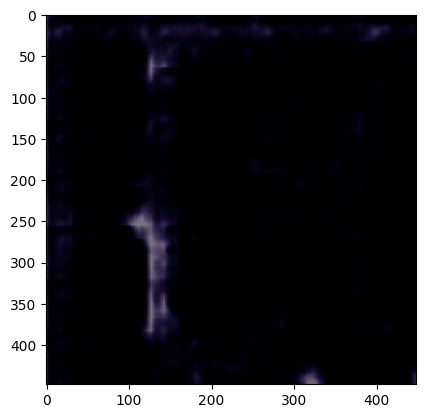

In [68]:
encoded_image = vae.encoder(imgs[0].reshape(-1,448,448,3))
decoded_image = vae.decoder(encoded_image[0])
plt.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))

In [64]:
plt.imshow((final_decoder(latent_space * 255).numpy().reshape(448,448,3).astype(np.uint8))

SyntaxError: unexpected EOF while parsing (3202694873.py, line 1)

In [40]:
#encoder = build_encoder(latent_dimension=800)


In [41]:
#decoder = build_decoder(latent_dimension=800)

In [42]:
encoder.summary()

NameError: name 'encoder' is not defined

In [43]:
decoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 800)]             0         
                                                                 
 dense_10 (Dense)            (None, 3136)              2511936   
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 14, 14, 128)      73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 28, 28, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 56, 56, 32)       1846

In [44]:

def build_autoencoder(encoder, decoder):
    inp = Input((448, 448, 3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

autoencoder = build_autoencoder(encoder, decoder)

NameError: name 'encoder' is not defined

In [45]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse', optimizer='adam')

In [46]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

compile_autoencoder(autoencoder)
autoencoder.fit(X_train, X_train, epochs=1000, batch_size=32, callbacks=[es], verbose=1)


NameError: name 'autoencoder' is not defined

In [ ]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=32)# you can now display an image to see it is reconstructed well
    

In [ ]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((prediction[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(448, 448, 3))
    plt.show()

In [ ]:
#autoencoder.save('autoencoder-latent-dim-800.h5')

In [ ]:
# !pip install opencv-python

In [ ]:
import cv2
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter('video.mp4', fourcc, 25.0, (448, 448))

for i in range(len(prediction)):
    image = prediction[i]
    image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    video_writer.write(image)
    
video_writer.release()
prediction = (prediction * 255).astype(np.uint8)

fps = 2
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (prediction.shape[2], prediction.shape[1]))
for i in range(aj.shape[0]):
    data = prediction[i, :, :, :]
    data = cv2.cvtColor(data, cv2.COLOR_RGB2BGR)
    out.write(data)
out.release()